# Gaussian process demo
A gaussian process is a type of stochastic process which is a set of random variables that are indexed over time or defined over time, and usually has this notation ${\displaystyle \{X(t)\}_{t\in T}}$ or just $X_{t}$.

A Gaussian process is usually notated like this:
$$f(x) \sim GP(m(x), k(x,x'))$$

#### Goals
The goals are to first:
1. get ode parameter estimation working with GPR. On one biomarker curve, with known timepoints.
2. expand to multiple patients with multiple biomarkers. 
3. using synthetic patients and no known timepoints, find time parameters of each observation with respect to the biomarkers.

## 1. ODE Parameter Fitting using LSQ


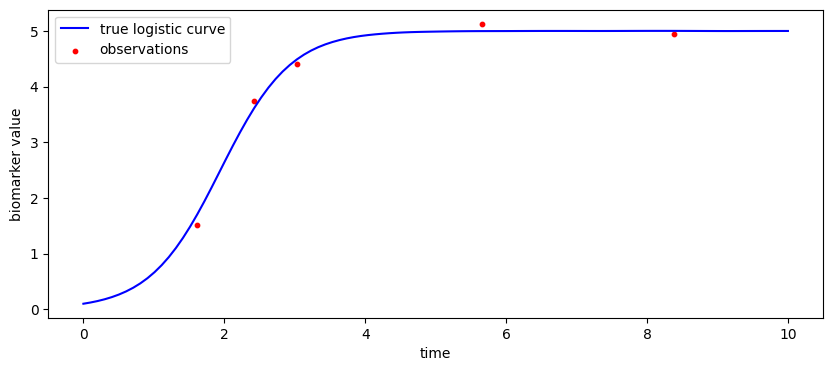

In [25]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Logistic ode defines the progression of our biomarker
def logistic_ODE(t, y, k=1, a=1):
    return (k / a) * y * (a - y)

# ground truth
a_true = 5  # I dont know
k_true = 2  # steepness
y0_true = 0.1  # inflection point

t_eval = np.linspace(0, 10, 100)

# solve
sol = solve_ivp(logistic_ODE, t_span=(min(t_eval), max(t_eval)),
    y0=[y0_true], args=(k_true, a_true), t_eval=t_eval, method="RK45")

# additive noise
np.random.normal(0, 0.1, size=sol.y[0].shape)

num_obs = 5 # think about this as number of patient scans

np.random.seed(2)
random_idx = np.random.choice(np.arange(len(sol.t)), size=num_obs, replace=False)
random_idx = np.sort(random_idx)

t_obs = sol.t[random_idx]
y_obs = sol.y[0][random_idx] + np.random.normal(0, 0.1, size=sol.y[0][random_idx].shape)

# truth plot
plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], label="true logistic curve", color="blue")
plt.scatter(t_obs, y_obs, label="observations", color="red", s=10)
plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.show()

Implementing LSQ fitting by taking in a parameter "guess", to feed into our ODE, then we evaluate our guess against the observations accordingly to minimize residuals.

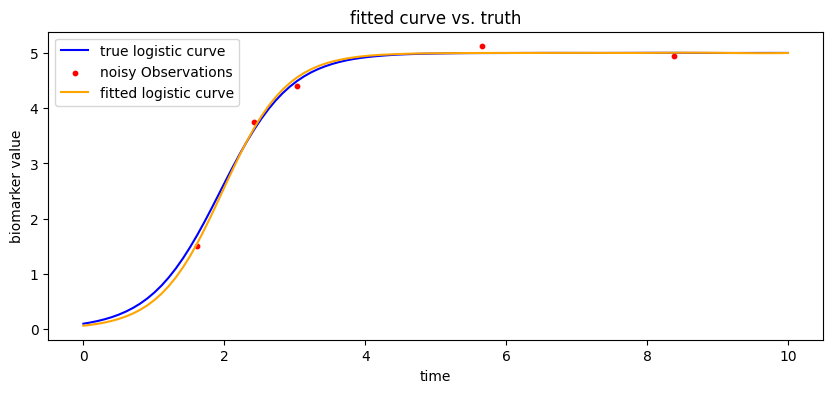

2.2038819267496184
4.999739571450092


In [26]:

def lsq_ODE(params, t_obs, y_obs, f_ODE=logistic_ODE):
    """
    Takes in a ODE function, with an array of guesses for each parameter.
    Computes ODE using guesses and then computes residuals using observations
    to be used in optimization.
    
    Returns:
    - residuals (np.ndarray): difference between predicted and observed
    """
    k, a, y0 = params
    # solve the ODE with the current parameter guesses
    sol = solve_ivp(f_ODE, t_span=(min(t_obs), max(t_obs)), 
        y0=[y0], args=(k, a), t_eval=t_obs,method="RK45",
    )
    # compute residuals
    return y_obs - sol.y[0][random_idx]

# def lsq_ODE(params, x, data, f_ODE=logistic_ODE):
#
#     y0_ode = params['y0_ode'].value
#     args_ode = []
#     for key in params.keys():
#         if key != 'y0_ode':
#             args_ode.append(params[key].value)
#     args_ode = tuple(args_ode)    
#     sol = solve_ivp(f_ODE, t_span=(min(x),max(x)), y0 = [y0_ode], args=args_ode, t_eval = x, method='DOP853')     
#     return data - sol.y

# min1 = minimize(lsq_ODE, params = params, args=(t_eval, sig), ftol=1e-20, gtol=1e-20, xtol=1e-20, max_nfev=20000) # fcn_kws= {'x':t_eval,'data': sig})#, 'f_ODE': logistic_ODE})
# report_fit(min1)

# initial parameter guesses
params_guess = [1, 4, 0.2]  # [k, a, y0]

# Optimize parameters using least squares
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
# https://stackoverflow.com/questions/18985048/error-using-l-bfgs-b-in-scipy
# https://www.youtube.com/watch?v=G0yP_TM-oag intro video

result = minimize(
    lambda p: np.sum(lsq_ODE(p, t_eval, y_obs) ** 2), params_guess,
    method="L-BFGS-B", bounds=[(0.1, 10), (0.1, 10), (0, 5)])
# using L-BFGS-B minimizer to use bounds

# extract fitted parameters
k_fit, a_fit, y0_fit = result.x

# solve ODE but with fitted parameters
sol_fit = solve_ivp(logistic_ODE, t_span=(min(t_eval), max(t_eval)),
    y0=[y0_fit], args=(k_fit, a_fit), t_eval=t_eval, method="RK45")

# Plot results
plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], label="true logistic curve", color="blue")
plt.scatter(t_obs, y_obs, label="noisy Observations", color="red", s=10)
plt.plot(sol_fit.t, sol_fit.y[0], label="fitted logistic curve", color="orange")
plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.title("fitted curve vs. truth")
plt.show()

print(k_fit)
print(a_fit)


## 2. Gaussian Process Regression (GPR) Sklearn demo
Where f(**x**) is not just a function, its a real process, and m(**x**) is the mean function which is just E(f(x)), (the GP people usually set it equal to 0), and k(**x**,**x**') is the covariance function, which defines how related the real process is to its derivative.

Let's start with a very simple demo of GPR, on an individual with one biomarker and then we will layer on complexity. This demo is from: https://scikit-learn.org/1.5/auto_examples/gaussian_process/plot_gpr_noisy_targets.html. This GPR demo will estimate the function that defines the set of points given to the GPR, later we will modify it to fit ODE parameters.

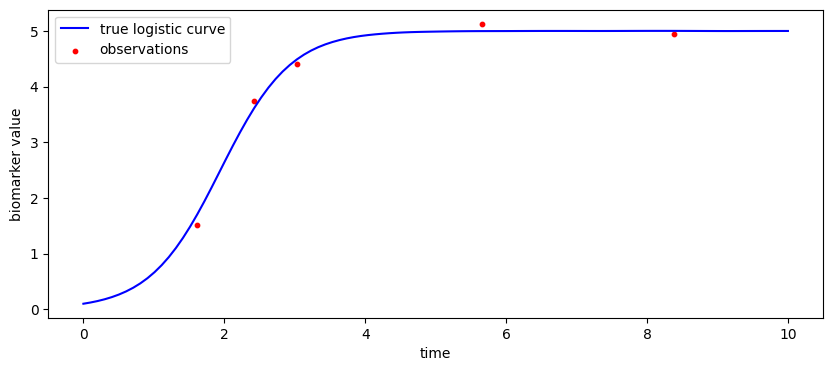

In [27]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Logistic ode defines the progression of our biomarker
def logistic_ODE(t, y, k=1, a=1):
    return (k / a) * y * (a - y)

# ground truth
a_true = 5  # I dont know
k_true = 2  # steepness
y0_true = 0.1  # inflection point

t_eval = np.linspace(0, 10, 100)

# solve
sol = solve_ivp(logistic_ODE, t_span=(min(t_eval), max(t_eval)),
    y0=[y0_true], args=(k_true, a_true), t_eval=t_eval, method="RK45")

num_obs = 5 # think about this as number of patient scans
np.random.seed(2)
random_idx = np.random.choice(np.arange(len(sol.t)), size=num_obs, replace=False)
random_idx = np.sort(random_idx)

t_obs = sol.t[random_idx]
y_obs = sol.y[0][random_idx] + np.random.normal(0, 0.1, size=sol.y[0][random_idx].shape)

# truth plot
plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], label="true logistic curve", color="blue")
plt.scatter(t_obs, y_obs, label="observations", color="red", s=10)
plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.show()

In [37]:
X = t_eval.reshape(-1,1)
y = sol.y[0].reshape(-1,1)

rng = np.random.RandomState(2)
training_indices = rng.choice(np.arange(y.size), size=5, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

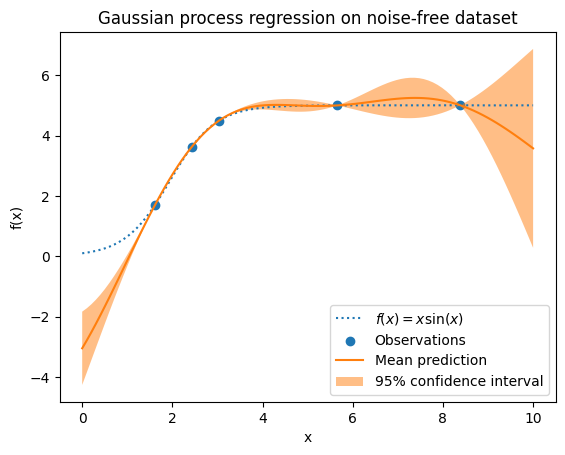

In [39]:

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted") # U CAN USE LATEX IN PYTHON????
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
_ = plt.title("Gaussian process regression on noise-free dataset")

This is not at all what we want to do. But this is just to get an idea about how gaussian process. We are assuming that biomarkers progress in a logistic way, therefore we would like our output to be sigmoidal. **We want to use GP regression to find the parameters of our disease biomarker.** However it should be noted, that later on we will want to remove any time related data from the training data, becuase that is truly unknown to us, but we will cross that bridge once we get there.

## 3. GPR Parameter estimation.
Now the question is can we produce the same type of outcome using GPR as the LSQ optimization to recover our biomarker progression.

/home/dsemchin/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


1.0 4.486388081063371


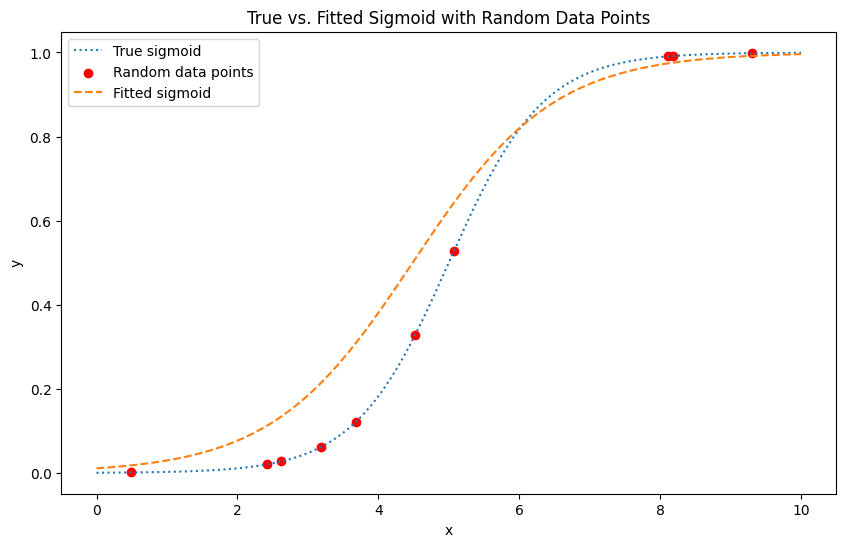

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


def sigmoid_ode(x, k, x0):
    return 1 / (1 + np.exp(-k * (x - x0)))

true_k, true_x0 = 1.5, 5.0
X = np.linspace(0, 10, 1000).reshape(-1, 1)
y_true = sigmoid_ode(X, true_k, true_x0)

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y_true.size), size=10, replace=False)
X_train, y_train = X[training_indices], y_true[training_indices]

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)

def loss(params):
    k, x0 = params
    y_pred, _ = gaussian_process.predict(X, return_std=True)
    y_ode = sigmoid_ode(X, k, x0)
    return np.mean((y_pred - y_ode) ** 2)

initial_guess = [1.0, 5.0]
result = minimize(loss, initial_guess, bounds=[(1.0, 3.0), (0, 10)]) 
fitted_k, fitted_x0 = result.x

print(fitted_k, fitted_x0)
y_fitted = sigmoid_ode(X, fitted_k, fitted_x0)

plt.figure(figsize=(10, 6))
plt.plot(X, y_true, label="True sigmoid", linestyle="dotted")
plt.scatter(X_train, y_train, color="red", label="Random data points")
plt.plot(X, y_fitted, label="Fitted sigmoid", linestyle="--")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("True vs. Fitted Sigmoid with Random Data Points")
plt.show()
